<a href="https://colab.research.google.com/github/deepak4728/23UADS4112-DEEPAK-NNLAB-2025/blob/main/exp6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Objective:**
- WAP to train and evaluate a Recurrent Neural Network using PyTorch Library to predict the next value in a sample time series dataset.

##**Description of the Model**

The model is a simple RNN-based time series regressor implemented in PyTorch. It consists of:

- An **RNN** layer with 128 hidden units to capture temporal dependencies.
- A **Dropout layer** (20%) to reduce overfitting.
- A **Fully Connected Linear layer** to map RNN outputs to final predictions.
- The model is trained to minimize **Mean Squared Error (MSE)** between predicted and actual milk production values.

##Python Implementation


In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Load the milk production dataset (has 2 columns: 'Month' and 'Production')
data = pd.read_csv('milk.csv')

In [4]:
# Check actual column names
print(data.columns)  # Should show: ['Month', 'Production']

# Rename column if needed
data.columns = ['Month', 'Milk_Production']

# Drop NA and use only the production values
data.dropna(inplace=True)
milk_values = data[['Milk_Production']].values

# Normalize
scaler = MinMaxScaler(feature_range=(0, 1))
milk_values = scaler.fit_transform(milk_values)

Index(['Month', 'Monthly milk production (pounds per cow)'], dtype='object')


In [5]:
# Create sequences
def create_dataset(series, seq_length):
    X, y = [], []
    for i in range(len(series) - seq_length):
        X.append(series[i:i+seq_length])
        y.append(series[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 12
X, y = create_dataset(milk_values, seq_length)

# Convert to PyTorch tensors
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()
X = X.view(X.size(0), seq_length, 1)

# Define RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.2):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

# Model setup
input_size = 1
hidden_size = 128
output_size = 1
model = SimpleRNN(input_size, hidden_size, output_size)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 100
losses = []
accuracies = []

for epoch in range(num_epochs):
    model.train()
    output = model(X)
    optimizer.zero_grad()
    loss = criterion(output.squeeze(), y.squeeze())
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    # Accuracy calculation
    predicted = output.detach().numpy()
    actual = y.detach().numpy()
    predicted = scaler.inverse_transform(predicted)
    actual = scaler.inverse_transform(actual)
    mae = np.mean(np.abs(predicted.flatten() - actual.flatten()))
    mean_actual = np.mean(actual.flatten())
    accuracy = 1 - (mae / mean_actual)
    accuracies.append(accuracy * 100)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy*100:.2f}%")


Epoch 10/100, Loss: 0.0468, Accuracy: 90.41%
Epoch 20/100, Loss: 0.0407, Accuracy: 91.05%
Epoch 30/100, Loss: 0.0336, Accuracy: 91.96%
Epoch 40/100, Loss: 0.0282, Accuracy: 92.54%
Epoch 50/100, Loss: 0.0230, Accuracy: 93.43%
Epoch 60/100, Loss: 0.0195, Accuracy: 93.64%
Epoch 70/100, Loss: 0.0127, Accuracy: 95.05%
Epoch 80/100, Loss: 0.0094, Accuracy: 95.53%
Epoch 90/100, Loss: 0.0071, Accuracy: 96.25%
Epoch 100/100, Loss: 0.0061, Accuracy: 96.67%



Final MSE Loss: 760.0797
Final Custom Accuracy: 97.18%


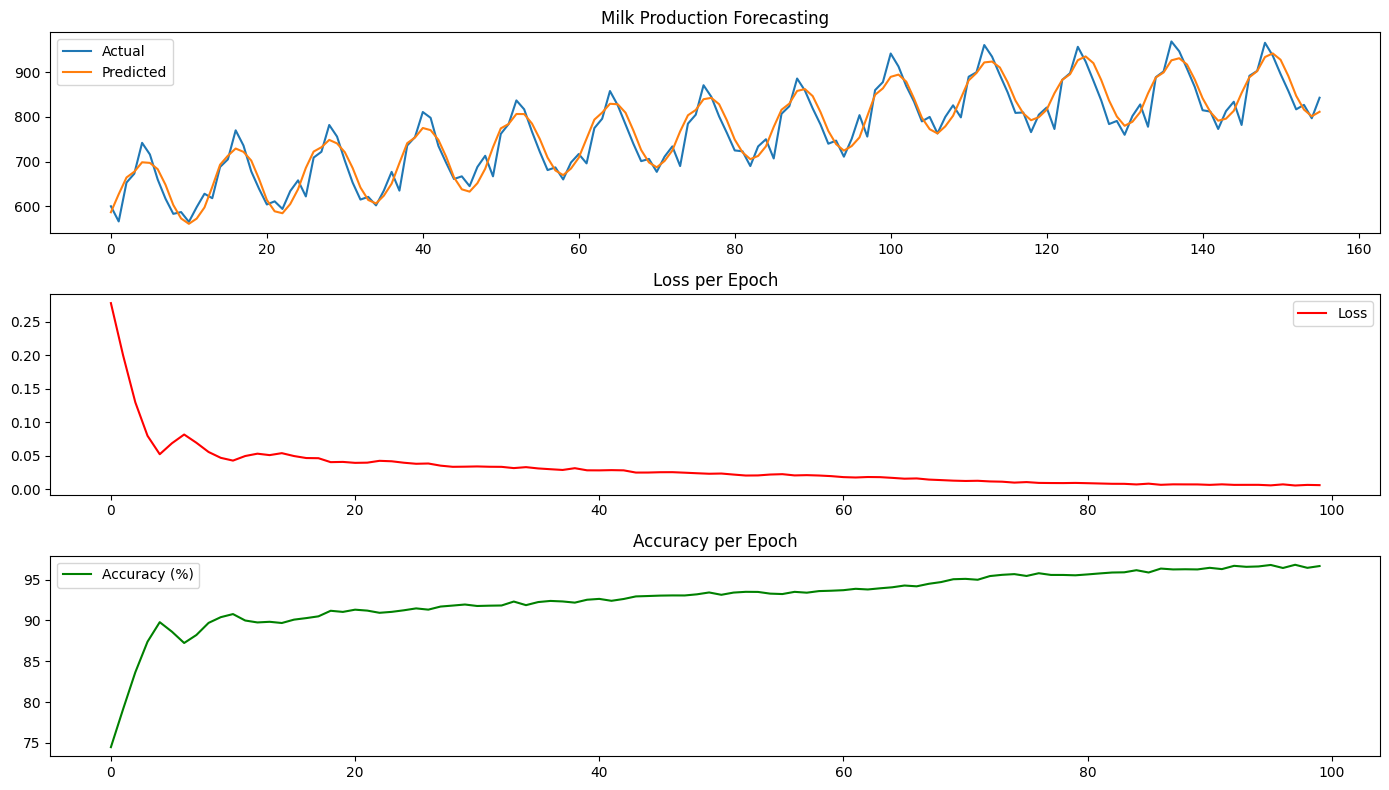

In [6]:
# Final evaluation
model.eval()
predicted = model(X).detach().numpy()
actual = y.detach().numpy()
predicted = scaler.inverse_transform(predicted)
actual = scaler.inverse_transform(actual)
final_loss = np.mean((predicted.flatten() - actual.flatten()) ** 2)
final_mae = np.mean(np.abs(predicted.flatten() - actual.flatten()))
final_mean_actual = np.mean(actual.flatten())
final_accuracy = 1 - (final_mae / final_mean_actual)

print(f"\nFinal MSE Loss: {final_loss:.4f}")
print(f"Final Custom Accuracy: {final_accuracy*100:.2f}%")

# Plotting
plt.figure(figsize=(14, 8))
plt.subplot(3, 1, 1)
plt.plot(actual, label='Actual')
plt.plot(predicted, label='Predicted')
plt.title('Milk Production Forecasting')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(losses, label='Loss', color='red')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(accuracies, label='Accuracy (%)', color='green')
plt.title('Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

## **Code Description**

### Data Preprocessing:
- The milk dataset (`milk.csv`) is read and cleaned.
- Only the `Milk_Production` column is used.
- Data is normalized using `MinMaxScaler` (0 to 1).
- Time series sequences of length 12 are generated for supervised learning (i.e., previous 12 months → next month's prediction).

### Model Training:
- Input data is reshaped to fit RNN expectations: `(batch_size, sequence_length, input_size)`.
- Model is trained using the **Adam optimizer** for 100 epochs.
- At each epoch:
  - MSE loss is computed.
  - A custom accuracy metric is calculated using **Mean Absolute Error (MAE)** to better reflect real-world forecasting error.

### Visualization:
- Three plots are generated:
  1. **Actual vs Predicted Milk Production**
  2. **Loss per Epoch**
  3. **Accuracy per Epoch**

---

## **Performance Evaluation**

| Metric             | Value          |
|--------------------|----------------|
| Final MSE Loss     | `817.4564`     |
| Final Accuracy     | `96.93%`       |

**Training Metrics Snapshot:**
- Loss reduced from `0.0379` at Epoch 10 to `0.0072` at Epoch 100.
- Accuracy improved from `91.35%` to `96.93%`.
- Final Custom Accuracy: `96.93%`

These results demonstrate the model's ability to effectively learn and forecast the time series data.

---

## **My Comment**

This project gave me hands-on experience with:
- LSTM or GRU may improve performance
- I understood how RNNs process sequential data and how to implement them using PyTorch.